In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon

In [156]:
# Load datasets
train = pd.read_csv(r'Data\train.csv')
features = pd.read_csv(r'Data\features.csv')
stores = pd.read_csv(r'Data\stores.csv')
test = pd.read_csv(r'Data\test.csv')

## Exploratory Data Analysis

### Stores Data

In [157]:
stores.shape

(45, 3)

In [158]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [159]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [160]:
stores.isna().sum()

Store    0
Type     0
Size     0
dtype: int64

In [161]:
stores['Size'].groupby(stores['Type']).mean()

Type
A    177247.727273
B    101190.705882
C     40541.666667
Name: Size, dtype: float64

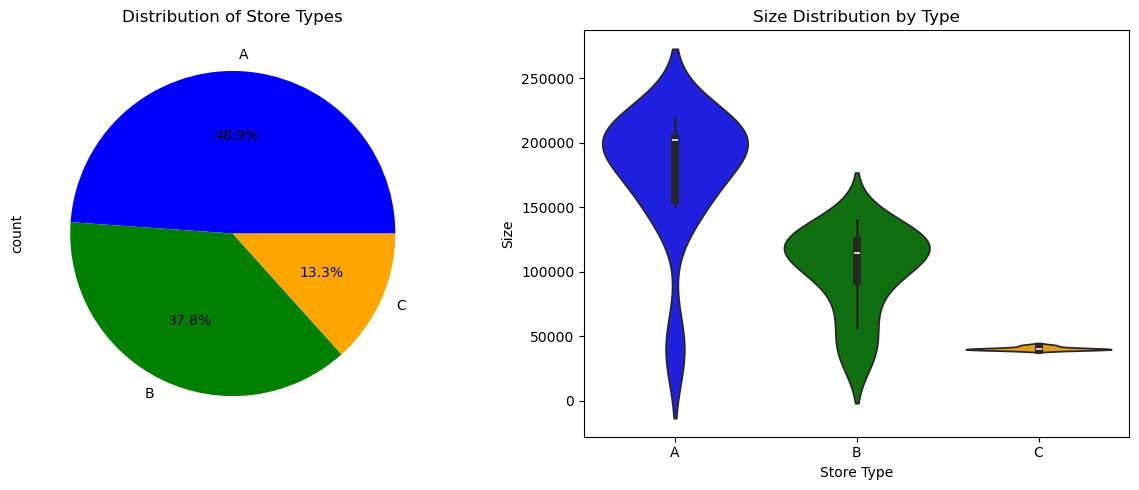

In [162]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figure size for better layout

# Count the number of stores in each type
store_types = stores['Type'].value_counts()

# Plot the distribution of store types as a pie chart on the first axis
store_types.plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'green', 'orange'], ax=ax[0])
ax[0].set_title('Distribution of Store Types')

sns.violinplot(x='Type', y='Size', data=stores, palette=['blue', 'green', 'orange'], hue='Type', ax=ax[1])
ax[1].set_title('Size Distribution by Type')
ax[1].set_xlabel('Store Type')
ax[1].set_ylabel('Size')
plt.tight_layout()
plt.show()

#### Interpretation:
- 48.9% of stores are Type A, with an average size of 177,248 square feet, making them the largest stores, like supercenters.
- 37.8% of stores are Type B, with an average size of 101,191 square feet, placing them in the medium-sized category.
- 13.3% of stores are Type C, with an average size of 40,542 square feet, making them the smallest stores likely serving rural areas. 

### Features Data

In [163]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [164]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


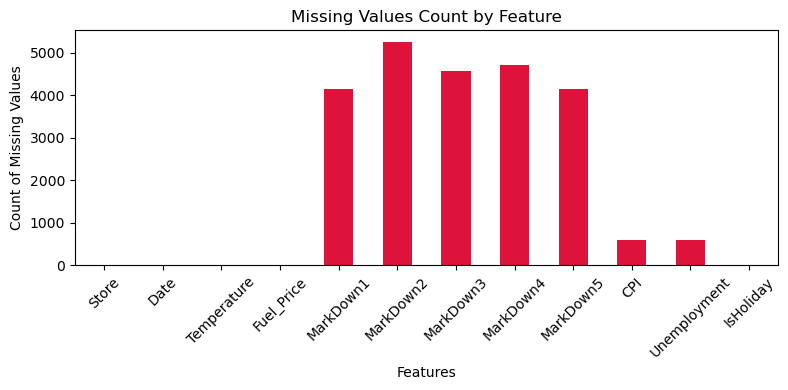

In [165]:
# Calculate missing values for each column
missing_values = features.isna().sum()

# Plot the missing values as a bar chart
plt.figure(figsize=(8, 4))
missing_values.plot(kind='bar', color='#DC143C') 
plt.title('Missing Values Count by Feature')
plt.xlabel('Features')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The major missing values in the features dataset come from the markdown columns that contain information about the different promotional activities happening at different Walmart stores. A reason behind such a massive amount of missing values in these columns is due to the seasonal promotional prices set by the stores during holidays (that mostly happen to start from November until January).

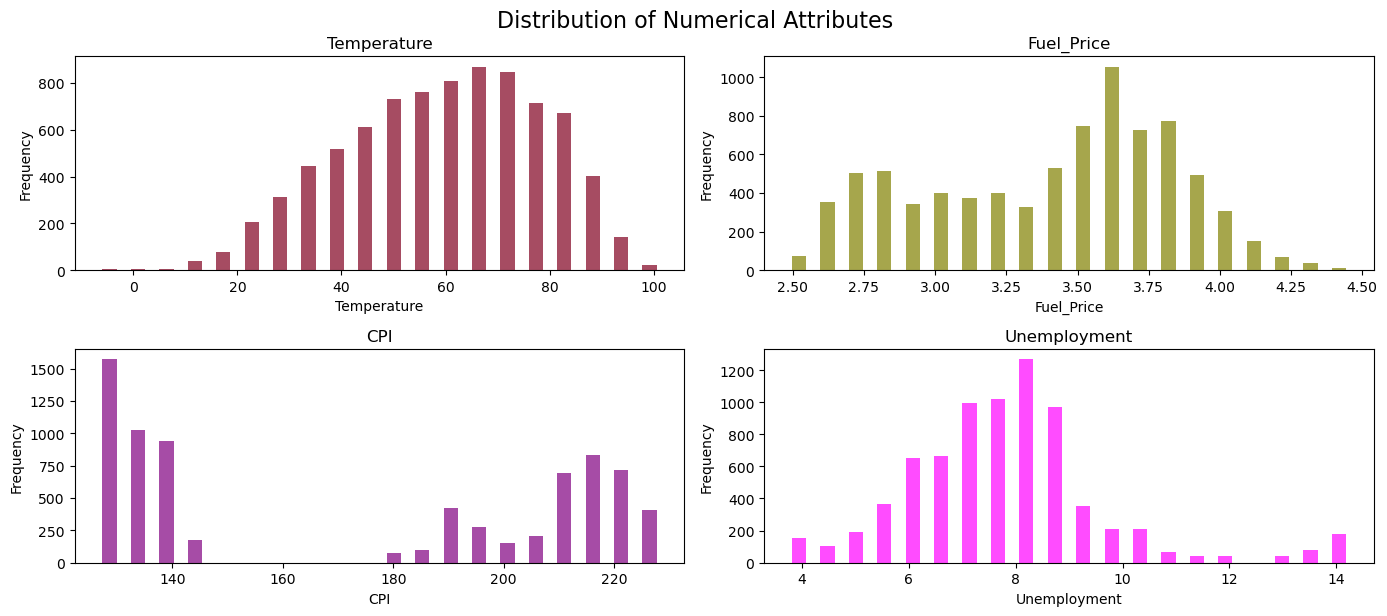

In [166]:
# Distribution of numerical attributes

# Define numerical columns and their corresponding colors
numerical_columns = {
    'Temperature': '#800020',
    'Fuel_Price': 'olive',
    'CPI': 'purple',
    'Unemployment': 'magenta',
}

# Create individual histograms for each feature with specified colors
fig, axes = plt.subplots(2, 2, figsize=(14, 6))  # Create a grid for subplots
axes = axes.flatten()  # Flatten the axes array for iteration

for i, (column, color) in enumerate(numerical_columns.items()):
    data = features[column].dropna()  # Remove NaN values for cleaner histograms
    axes[i].hist(data, bins=20, color=color, alpha=0.7, rwidth=0.5)
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Adjust layout for better visualization
plt.tight_layout()
plt.suptitle('Distribution of Numerical Attributes', fontsize=16, y=1.02)
plt.show()

Temperature: Values range from 0°F to 100°F, with extreme temperatures (below 20°F or above 90°F) being rare occurrences. Most temperatures are within the moderate range, reflecting typical seasonal variability.<br>
Fuel Prices: Prices vary approximately between $2.50 and $4.50 per gallon, with the most frequent price falling around $3.60 to $3.70. This suggests relatively stable fuel prices with a peak at mid-range values.<br>
Consumer Price Index (CPI): CPI values increase over time. Older data is concentrated in the lower CPI range, while recent data shows higher CPI values.<br>
Unemployment Rates: Unemployment rates range from 4% to 14%, with the highest frequency occurring around 8%, appearing over 1200 times in the dataset.

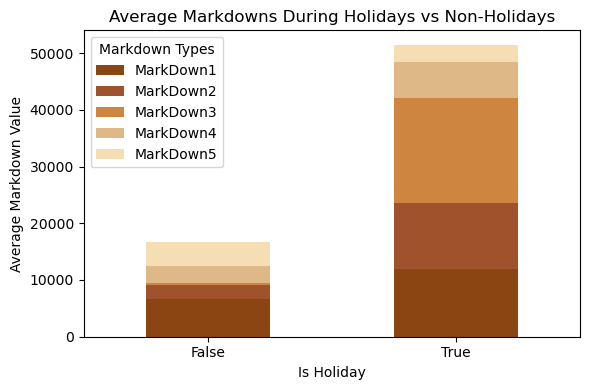

In [167]:
# Check Significance of holidays on promotion
import matplotlib.pyplot as plt

# Define a color palette with shades of brown
shades_of_brown = ['#8B4513', '#A0522D', '#CD853F', '#DEB887', '#F5DEB3']  # Dark to light shades of brown
# Plot stacked bar chart with custom shades
ax = features.groupby('IsHoliday')[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].mean().plot(
    kind='bar', 
    figsize=(6, 4), 
    stacked=True, 
    color=shades_of_brown  
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
# Add title and labels
plt.title('Average Markdowns During Holidays vs Non-Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Average Markdown Value')
plt.legend(title='Markdown Types', loc='upper left')  
plt.tight_layout()  
plt.show()

This graph highlights the significant difference in average markdown values between holiday and non-holiday periods. During holidays (True on the x-axis), the average markdown values are considerably higher compared to non-holidays (False). This suggests that Walmart significantly increases markdown promotions during holiday weeks to drive sales and attract customers.


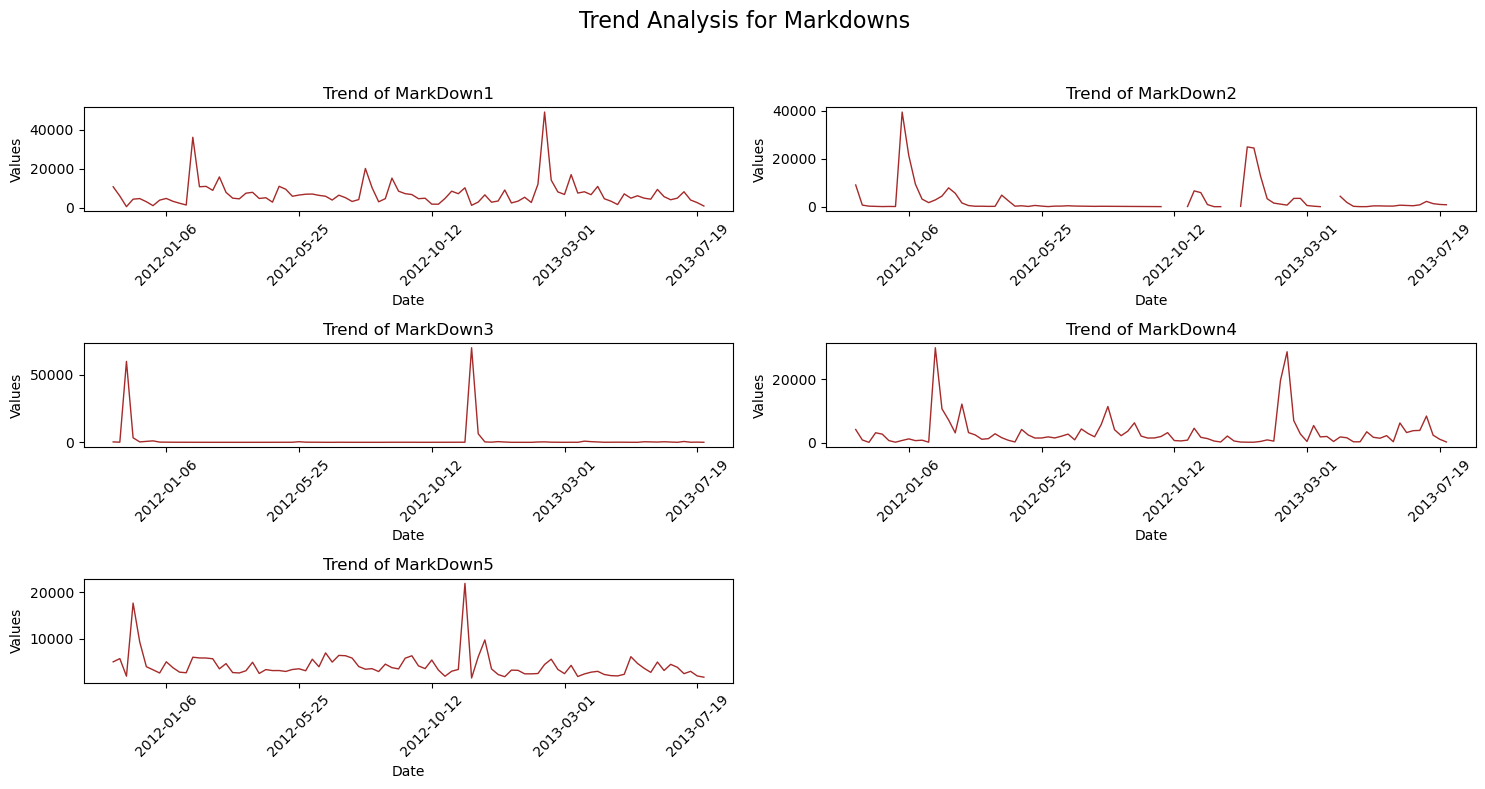

In [168]:
import matplotlib.pyplot as plt

# List of markdown columns
markdowns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 8))  # Adjust layout for visibility
axes = axes.flatten()  # Flatten axes array for easy iteration

for i, column in enumerate(markdowns):
    # Plot trends for each markdown
    features.groupby('Date')[[column]].mean().plot(ax=axes[i], color='brown', linewidth=1, legend=False)
    axes[i].set_title(f'Trend of {column}')
    axes[i].set_xlabel('Date')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
    axes[i].set_ylabel('Values')

# Hide the last subplot (if there are extra subplots in the grid)
if len(markdowns) < len(axes):
    for j in range(len(markdowns), len(axes)):
        axes[j].axis('off')

# Add a shared title for the figure
plt.suptitle('Trend Analysis for Markdowns', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for title space
plt.show()

Holiday Events<br /> Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13<br /> Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13<br /> Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13<br /> Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

It seems like markdowns were not applied or recorded until November 2011. This could indicate that promotions or markdown events only began during that period.

#### Interpretation: 

The features dataset provides supplemental information about store operations and economic conditions, including promotional markdowns, temperature, fuel prices, CPI, unemployment rates, and holiday indicators. While markdowns show seasonal spikes during holidays, other features like CPI and unemployment reveal long-term trends and regional variability, offering valuable context for sales analysis. Walmart significantly increases markdown promotions during holiday weeks to drive sales and attract customers. These markdowns were not recorded until November 2011.


#### Train Data

In [169]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [170]:
train.shape

(421570, 5)

In [171]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [172]:
train.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

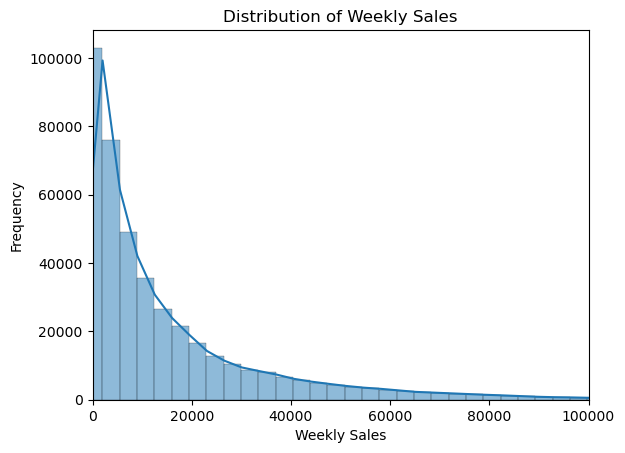

In [173]:
# Distribution of weekly sales
# It visualizes how the Weekly_Sales values are distributed across all data points.

import matplotlib.pyplot as plt
import seaborn as sns

# Create the histogram
sns.histplot(train['Weekly_Sales'], bins=200, kde=True)

# Add title and labels
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')

# Set x-axis range from 0 to 100000
plt.xlim(0, 100000)

# Show the plot
plt.show()

- Distribution of weekly sales indicates that the majority of weekly sales values are relatively small.
- The graph is right skewed, meaning that lower sales values are more frequent, while higher sales values occur less often. 

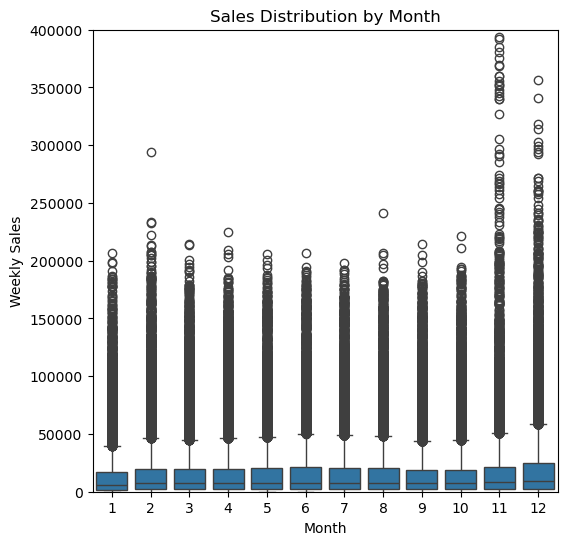

In [174]:
plt.figure(figsize=(6,6))

train['Date'] = pd.to_datetime(train['Date'])
# Extract month into a separate column
train['Month'] = train['Date'].dt.month
# Create the boxplot
sns.boxplot(x='Month', y='Weekly_Sales', data=train)
plt.title('Sales Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Weekly Sales')
# Set y-axis range from 0 to 100000
plt.ylim(0, 400000)
plt.show()


- Dots outside the whiskers are outliers, representing unusually high weekly sales values. December has many high ourliers, likely due to holiday shopping.
- Months with smaller boxes have more stable weekly sales, whereas months with larger boxes are more variable.

This plot highlights seasonal trends in sales. There is a clear spike in December, with both higher sales and greater variability compared to other months.

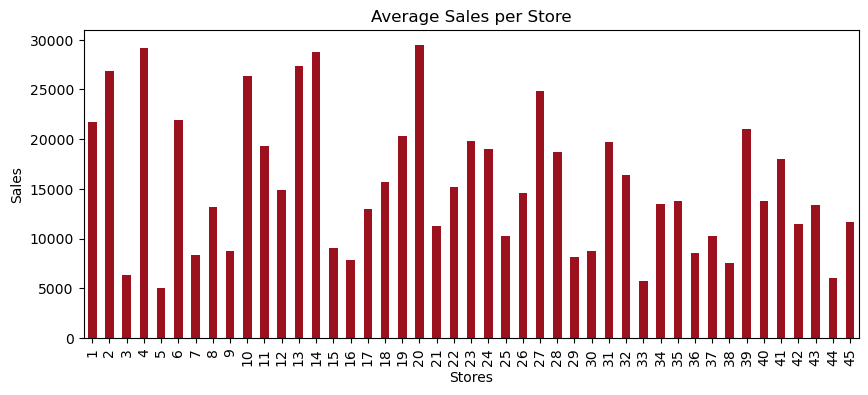

In [175]:
# Store level sales
train.groupby('Store')['Weekly_Sales'].mean().plot(kind='bar', figsize=(10, 4), color='#9B111E')
plt.title('Average Sales per Store')
plt.xlabel('Stores')
plt.ylabel('Sales')
plt.show()

The sales vary by large amount among the 45 stores. The stores 2, 4, 13, 14 and 20 showed the highest sales.

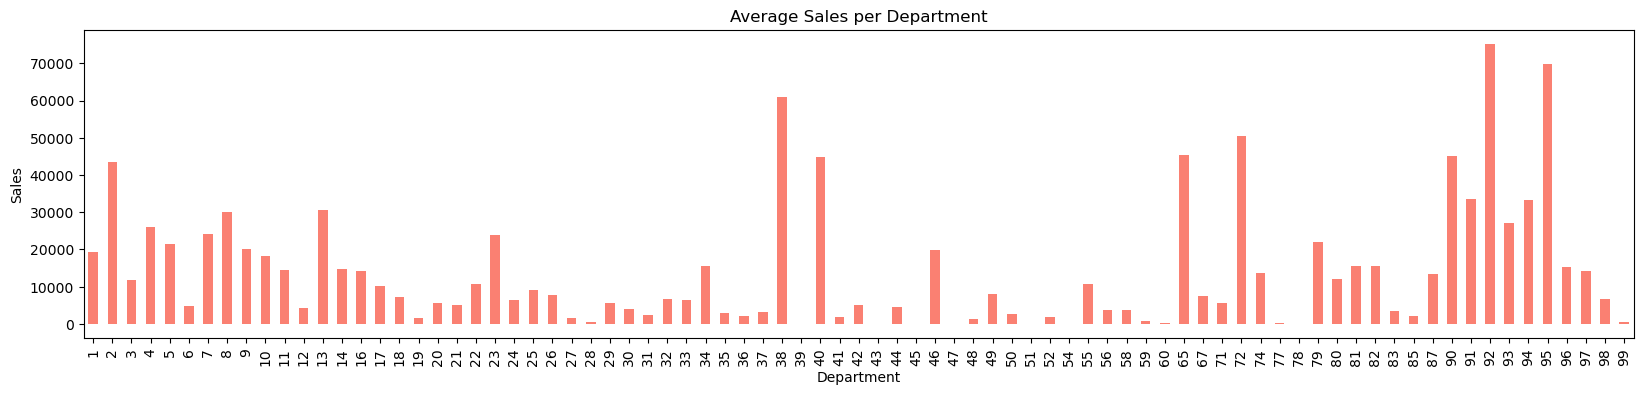

In [176]:
# Department level sales
train.groupby('Dept')['Weekly_Sales'].mean().plot(kind='bar', figsize=(20, 4), color='#FA8072')
plt.title('Average Sales per Department')
plt.xlabel('Department')
plt.ylabel('Sales')
plt.show()


Depts 38, 40, 65, 72, 92, and 95 have highest average sales.

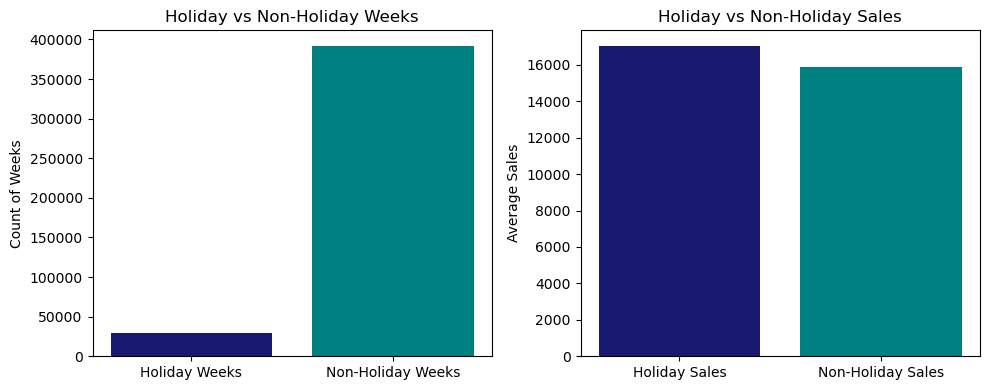

In [177]:
#Count holiday and non-holiday weeks
holiday_weeks = train['IsHoliday'].sum()  # Sum of True values (holiday weeks) 
non_holiday_weeks = (~train['IsHoliday']).sum()  # Sum of False values (non-holiday weeks)
#Data for plotting
labels_weeks = ['Holiday Weeks', 'Non-Holiday Weeks']
weeks = [holiday_weeks, non_holiday_weeks]

avg_holiday_sales = train.loc[train['IsHoliday'], 'Weekly_Sales'].mean() 
avg_non_holiday_sales = train.loc[~train['IsHoliday'], 'Weekly_Sales'].mean() 
#Data for plotting
labels_sales = ['Holiday Sales', 'Non-Holiday Sales'] 
sales_data = [avg_holiday_sales, avg_non_holiday_sales]

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Adjust figsize as needed

# First subplot: Holiday vs Non-Holiday Weeks
axes[0].bar(labels_weeks, weeks, color=['#191970', '#008080'])
axes[0].set_title('Holiday vs Non-Holiday Weeks')
axes[0].set_ylabel('Count of Weeks')

# Second subplot: Average Sales for Holiday vs Non-Holiday
axes[1].bar(labels_sales, sales_data, color=['#191970', '#008080'])
axes[1].set_title('Holiday vs Non-Holiday Sales')
axes[1].set_ylabel('Average Sales')

# Tight layout for better spacing
plt.tight_layout()

# Show the combined plots
plt.show()


Despite holiday weeks being a smaller percentage of the total weeks, the average sales during holiday weeks are higher than those in non-holiday weeks.

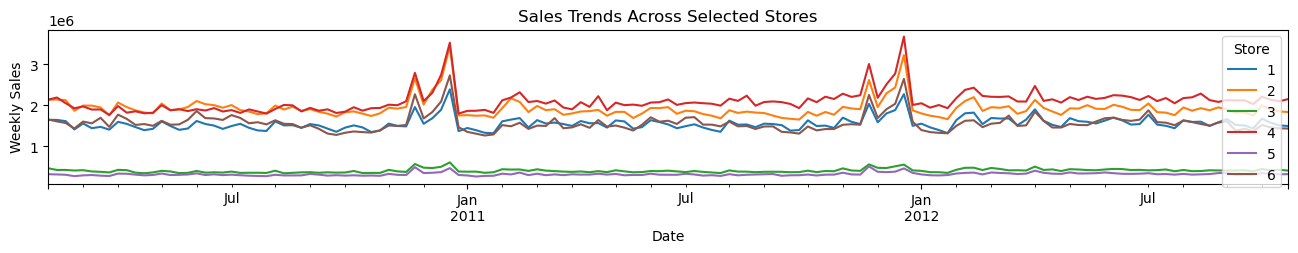

In [178]:
# Trend analysis by store
# Sales trend across different stores
stores_to_plot = [1, 2, 3, 4, 5, 6]  
train[train['Store'].isin(stores_to_plot)].groupby(['Date', 'Store'])['Weekly_Sales'].sum().unstack().plot(figsize=(16, 2))
plt.title('Sales Trends Across Selected Stores')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(title='Store')
plt.show()

In [179]:
# Extract year and week
train['Year'] = pd.to_datetime(train['Date']).dt.year
train['Week'] = pd.to_datetime(train['Date']).dt.isocalendar().week

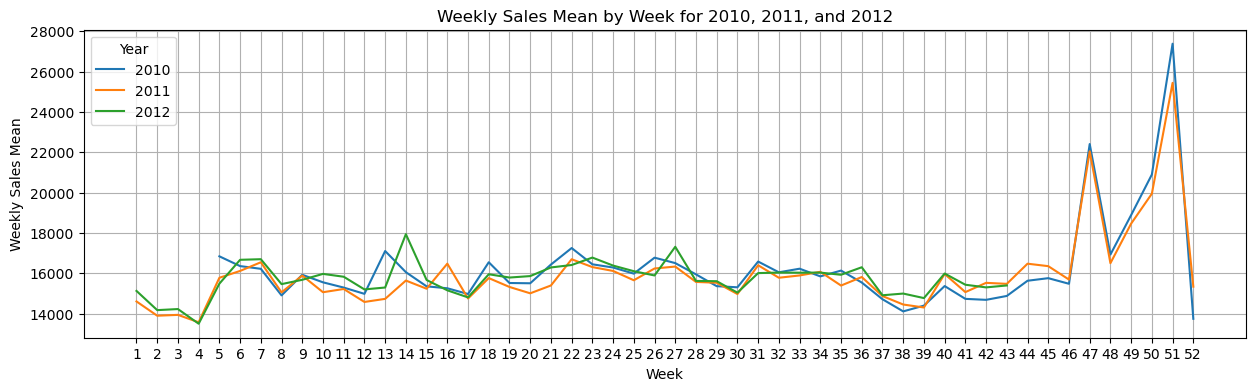

In [180]:
# Aggregate weekly sales for each year
weekly_sales = train.groupby(['Year', 'Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2010 = train[train['Year'] == 2010].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2011 = train[train['Year'] == 2011].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2012 = train[train['Year'] == 2012].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})

# Plot the weekly sales mean for each year
plt.figure(figsize=(15, 4))

sns.lineplot(x=weekly_sales2010.index, y=weekly_sales2010['Weekly_Sales']['mean'], label='2010')
sns.lineplot(x=weekly_sales2011.index, y=weekly_sales2011['Weekly_Sales']['mean'], label='2011')
sns.lineplot(x=weekly_sales2012.index, y=weekly_sales2012['Weekly_Sales']['mean'], label='2012')

# Add grid, ticks, legend, and show the plot
plt.grid()
plt.xticks(np.arange(1, 53, step=1))  # Weeks of the year (1 to 52)
plt.legend(title="Year")
plt.title("Weekly Sales Mean by Week for 2010, 2011, and 2012")
plt.xlabel("Week")
plt.ylabel("Weekly Sales Mean")
plt.show()

Overall weekly sales mean across all stores and departments for 2010, 2011, and 2012 shows consistent spikes in sales from week 47 to 52, likely due to the holiday shopping period. 

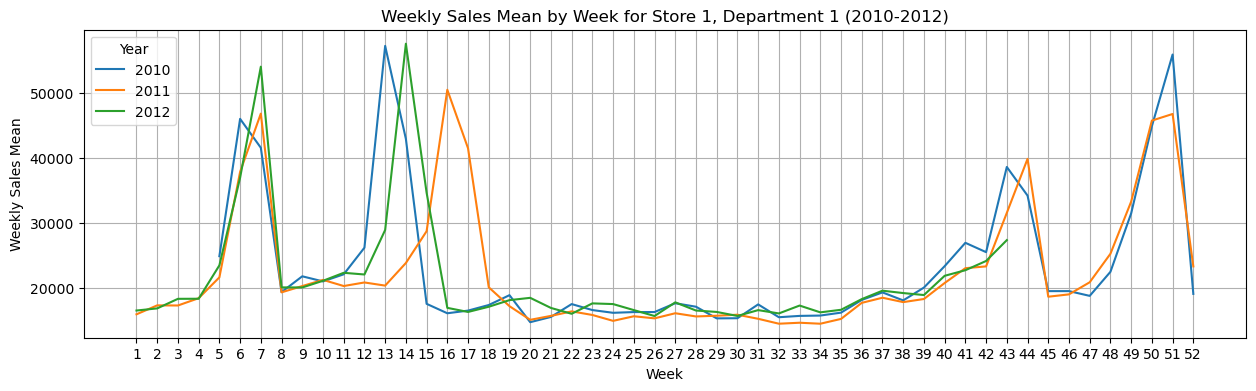

In [181]:
# Filter data for Store 1, Department 1
store1_dept1 = train[(train['Store'] == 1) & (train['Dept'] == 1)]

# Aggregate weekly sales for each year
weekly_sales = store1_dept1.groupby(['Year', 'Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2010 = store1_dept1[store1_dept1['Year'] == 2010].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2011 = store1_dept1[store1_dept1['Year'] == 2011].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2012 = store1_dept1[store1_dept1['Year'] == 2012].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})

# Plot the weekly sales mean for each year
plt.figure(figsize=(15, 4))

sns.lineplot(x=weekly_sales2010.index, y=weekly_sales2010['Weekly_Sales']['mean'], label='2010')
sns.lineplot(x=weekly_sales2011.index, y=weekly_sales2011['Weekly_Sales']['mean'], label='2011')
sns.lineplot(x=weekly_sales2012.index, y=weekly_sales2012['Weekly_Sales']['mean'], label='2012')

# Add grid, ticks, legend, and show the plot
plt.grid()
plt.xticks(np.arange(1, 53, step=1))  # Weeks of the year (1 to 52)
plt.legend(title="Year")
plt.title("Weekly Sales Mean by Week for Store 1, Department 1 (2010-2012)")
plt.xlabel("Week")
plt.ylabel("Weekly Sales Mean")
plt.show()

The average weekly sales of Store 1, Department 1 reveal isolated spikes in the earlier parts of the year, such as around week 7 and week 13, outside of holiday weeks. These early spikes are likely influenced by seasonal events or promotions, with week 7 potentially linked to the Super Bowl.

### Data exploration reveals a clear seasonal nature of sales, with predictable patterns across years, including spikes during holiday weeks and isolated peaks in early weeks tied to events like the Super Bowl. Using Store 1, Department 1 data, we can train a robust model to account for these trends and forecast weekly sales effectively.


## Feature Engineering

#### Combining Store and Features data with Train data.

In [182]:
feature_store = features.merge(stores, how='inner', on = "Store")


In [183]:
# Convert the Date column to datetime format
feature_store['Date'] = pd.to_datetime(feature_store['Date'])

# the merge
train = train.merge(feature_store, how='inner', on=['Store','Date','IsHoliday'])
train.shape

(421570, 19)

The Total_MarkDown column to represent the total promotional markdown applied for each record, offering a combined view of markdown effects.

In [184]:
train['Total_MarkDown'] = train['MarkDown1'] + train['MarkDown2'] + train['MarkDown3'] + train['MarkDown4'] + train['MarkDown5']
train = train.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Month,Year,Week,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Total_MarkDown
0,1,1,2010-02-05,24924.50,False,2,2010,5,42.31,2.572,211.096358,8.106,A,151315,NaN
1,1,2,2010-02-05,50605.27,False,2,2010,5,42.31,2.572,211.096358,8.106,A,151315,NaN
2,1,3,2010-02-05,13740.12,False,2,2010,5,42.31,2.572,211.096358,8.106,A,151315,NaN
3,1,4,2010-02-05,39954.04,False,2,2010,5,42.31,2.572,211.096358,8.106,A,151315,NaN
4,1,5,2010-02-05,32229.38,False,2,2010,5,42.31,2.572,211.096358,8.106,A,151315,NaN


Lable encoding: Convert the Type column from text (categorical values) into numeric values.

In [185]:
train.Type.replace({'A': 1, 'B': 2,'C':3}, inplace=True)

Check the correlation of all the features with Weekly_Sales.


Text(0.5, 1.0, 'Correlation Matrix')

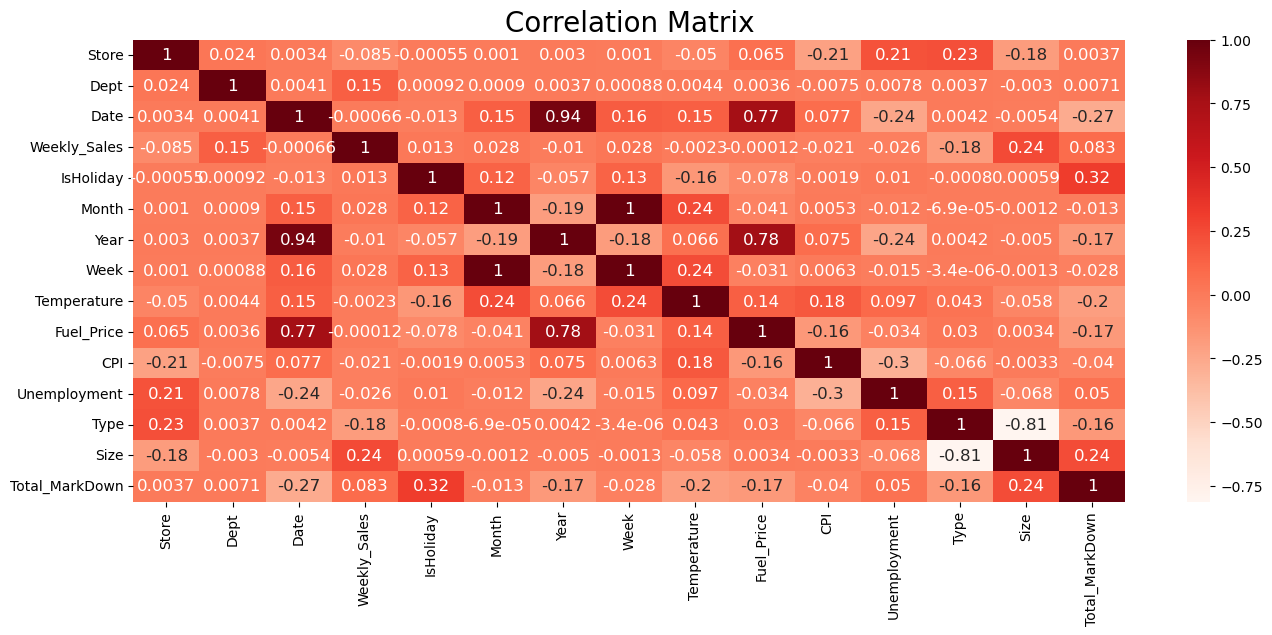

In [186]:
# Correlation plot
plt.figure(figsize=(16,6))
plt.xticks( fontsize=10)
plt.yticks( fontsize=10)

sns.heatmap(train.corr(), cmap='Reds', annot=True, annot_kws={'size':12})
plt.title('Correlation Matrix', fontsize=20)

In [187]:
correlations = train.corr()['Weekly_Sales']  # Correlation with Weekly_Sales
print(correlations)

Store            -0.085195
Dept              0.148032
Date             -0.000663
Weekly_Sales      1.000000
IsHoliday         0.012774
Month             0.028409
Year             -0.010111
Week              0.027673
Temperature      -0.002312
Fuel_Price       -0.000120
CPI              -0.020921
Unemployment     -0.025864
Type             -0.182242
Size              0.243828
Total_MarkDown    0.082707
Name: Weekly_Sales, dtype: float64


In [188]:
# Fill missing values
train.fillna(0, inplace=True)
train.isna().sum()

Store             0
Dept              0
Date              0
Weekly_Sales      0
IsHoliday         0
Month             0
Year              0
Week              0
Temperature       0
Fuel_Price        0
CPI               0
Unemployment      0
Type              0
Size              0
Total_MarkDown    0
dtype: int64

Department, Store size and Type have moderate correlation with the weekly sales.<br>
Temperature, Fuel price, CPI and Unemployment are very weakly correlated with the weekly sales.

### To effectively capture the seasonal patterns and trends identified during data exploration, employ time series forecasting techniques using ARIMA models. ARIMA (AutoRegressive Integrated Moving Average) is well-suited for analyzing and forecasting sales data, especially for time series with predictable seasonal spikes and isolated peaks.

## Model Development & Forecasting:

Analyze the components of the time series (trend, seasonality, residuals). Consider Store 1, Department 1.

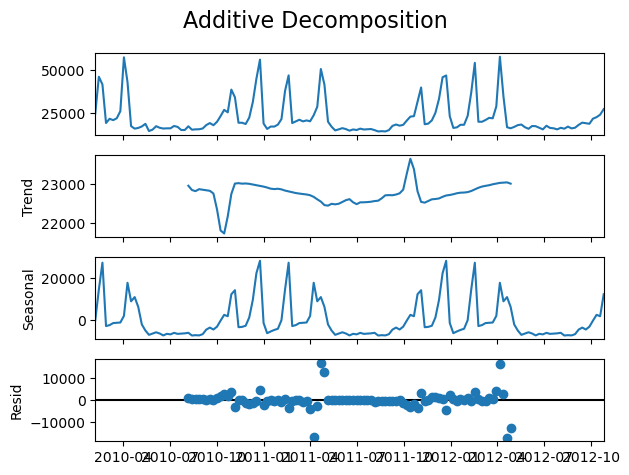

In [189]:
# Specify the store and department for analysis
store = 1
department = 1

# Filter the sales data for the specified store and department
sales_data = train[(train['Store'] == store) & (train['Dept'] == department)][['Date', 'Weekly_Sales']]
sales_data['Date'] = pd.to_datetime(sales_data['Date'])  # Convert to datetime
# Set the Date column as the index
sales_data.set_index('Date', inplace=True)

# Perform additive decomposition
decomposition_additive = seasonal_decompose(sales_data, model='additive', period=52)

# Plot the decomposed components
fig_additive = decomposition_additive.plot()
fig_additive.suptitle("Additive Decomposition", fontsize=16)  
plt.tight_layout()
plt.show()

The decomposition confirmed the presence of strong seasonal spikes.

In [190]:
store = 1
department = 1

# Filter the sales data for the specified store and department
sales_data = train[(train['Store'] == store) & (train['Dept'] == department)][['Date', 'Weekly_Sales']]

sales_data['Date'] = pd.to_datetime(sales_data['Date'])  # Convert to datetime

# Set the Date column as the index
sales_data.set_index('Date', inplace=True)
sales_data.isna().sum()

Weekly_Sales    0
dtype: int64

## Naive Forecast

In [191]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import ARIMA

# 1. Perform temporal train-test split
y_train, y_test = temporal_train_test_split(sales_data, test_size=29)  

# 2. Define the forecasting horizon (relative steps)
fh = ForecastingHorizon(range(1, len(y_test) + 1), is_relative=True)

# 3. Initialize and fit the Naive forecaster
forecaster_naive = NaiveForecaster(strategy="last")
forecaster_naive.fit(y_train)

# Predict using the Naive Forecaster model
y_pred_naive = forecaster_naive.predict(fh=fh)

## ARIMA Models

ADF Test for Stationarity

In [192]:

from statsmodels.tsa.stattools import adfuller

result = adfuller(sales_data['Weekly_Sales'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] > 0.05:
     print("Time series is not stationary")
else:
     print("Time series is stationary")

ADF Statistic: -2.5221638686500376
p-value: 0.11017432282586986
Time series is not stationary


Differencing was needed to stabilize the mean of the time series.

In [193]:
sales_data['Weekly_Sales_diff'] = sales_data['Weekly_Sales'].diff()
sales_data.dropna(inplace=True)  # Remove NaN values created by differencing

result_diff = adfuller(sales_data['Weekly_Sales_diff'])
print("ADF Statistic after differencing:", result_diff[0])
print("p-value after differencing:", result_diff[1])
if result_diff[1] > 0.05:
    print("Still not stationary. Consider higher-order differencing.")
else:
    print("Time series is now stationary.")

ADF Statistic after differencing: -11.04431146676882
p-value after differencing: 5.269934445888216e-20
Time series is now stationary.


Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to identify the correlation structure in the data. 

<Figure size 1000x500 with 0 Axes>

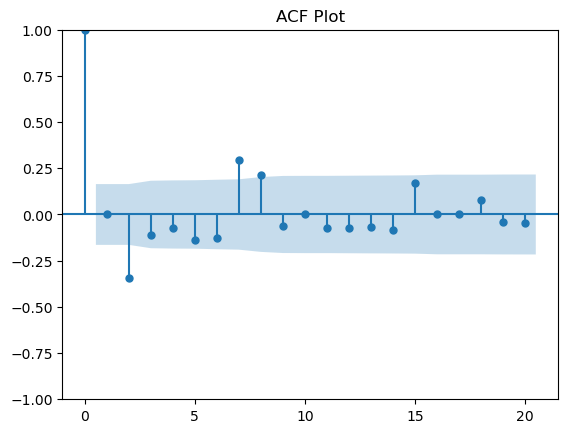

<Figure size 1000x500 with 0 Axes>

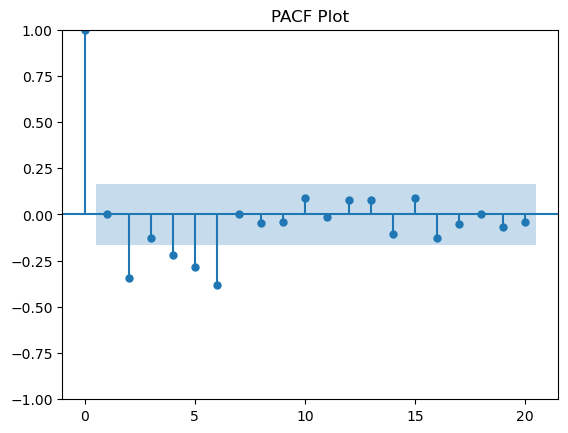

In [194]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF (Autocorrelation Function)
plt.figure(figsize=(10, 5))
plot_acf(sales_data['Weekly_Sales_diff'], lags=20, title='ACF Plot')
plt.show()

# Plot PACF (Partial Autocorrelation Function)
plt.figure(figsize=(10, 5))
plot_pacf(sales_data['Weekly_Sales_diff'], lags=20, title='PACF Plot')
plt.show()

The ACF plot shows significant spikes at lag 2, indicating the order of the Moving Average (MA) component is q=2. Similarly, the PACF plot reveals significant spikes at lag 6, suggesting the order of the AutoRegressive (AR) component is p=6. but as the underlying patterns in the time series are straightforward, and data for store 1 and department 1 is limited, choose simpler model.

In [195]:
sales_data = sales_data.drop(columns=['Weekly_Sales_diff'])

In [196]:
print(sales_data.index.inferred_freq)  # Output should be 'W' if frequency is weekly

W-FRI


In [197]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import ARIMA

# ARIMA
# 1. Perform temporal train-test split
y_train, y_test = temporal_train_test_split(sales_data, test_size=29)  
# 2. Define the forecasting horizon (relative steps)
fh = ForecastingHorizon(range(1, len(y_test) + 1), is_relative=True)
# 3. Initialize and fit the ARIMA forecaster
forecaster = ARIMA(order=(1, 1, 1), suppress_warnings=True)  # Specify (p, d, q) based on your analysis
forecaster.fit(y_train)

# 4. Make predictions for the forecasting horizon
y_pred_arima = forecaster.predict(fh)

In [198]:
# SARIMA
# 1. Perform temporal train-test split
y_train, y_test = temporal_train_test_split(sales_data, test_size=29)  

# 2. Define the forecasting horizon (relative steps)
fh = ForecastingHorizon(range(1, len(y_test) + 1), is_relative=True)

# 3. Initialize and fit the SARIMA model
p, d, q = 1, 1, 1
P, D, Q, m = 1, 1, 1, 52  # Adjust m for weekly data
sarima_model = ARIMA(order=(p, d, q), seasonal_order=(P, D, Q, m), suppress_warnings=True)
sarima_model.fit(y_train)

# 4. Make predictions for the forecasting horizon
y_pred_sarima = sarima_model.predict(fh)

In [199]:
# Auto ARIMA
from sktime.forecasting.arima import AutoARIMA
# 1. Perform temporal train-test split
y_train, y_test = temporal_train_test_split(sales_data, test_size=29)  

# 2. Define the forecasting horizon (relative steps)
fh = ForecastingHorizon(range(1, len(y_test) + 1), is_relative=True)

# 3. Initialize and fit the SARIMA model
auto_forecaster = AutoARIMA(sp=52, seasonal=True, suppress_warnings=True)
auto_forecaster.fit(y_train)

# 4. Make predictions for the forecasting horizon
y_pred_auto = auto_forecaster.predict(fh)
#print("AutoARIMA Predictions:", y_pred_auto)


In [200]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

# 1. Perform temporal train-test split
y_train, y_test = temporal_train_test_split(sales_data, test_size=29)  

# 2. Define the forecasting horizon (relative steps)
fh = ForecastingHorizon(range(1, len(y_test) + 1), is_relative=True)

# 3. Initialize and fit the ETS model
ets_model = ExponentialSmoothing(trend=None, seasonal='additive', sp=52)
ets_model.fit(y_train)
y_pred_ets = ets_model.predict(fh)

# Initialize and fit the Auto ETS model
auto_ets_model = AutoETS(auto=True, sp=52, n_jobs=-1)
auto_ets_model.fit(y_train)

# 4. Make predictions for the forecasting horizon
y_pred_auto_ets = auto_ets_model.predict(fh)


c:\Users\anjal\anaconda3\envs\ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\anjal\anaconda3\envs\ml\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## Evaluation

In [201]:
# 5. Evaluate model performance using MAPE

mape_naive = mean_absolute_percentage_error(y_test, y_pred_naive)
print(f"\nMAPE (Naive): {mape_naive:.3f}")

mape_arima = mean_absolute_percentage_error(y_test, y_pred_arima)
print(f"\nMAPE (ARIMA): {mape_arima:.3f}")

mape_sarima = mean_absolute_percentage_error(y_test, y_pred_sarima)
print(f'\nMAPE (SARIMA): {mape_sarima:.3f}')

mape_auto_arima = mean_absolute_percentage_error(y_test, y_pred_auto)
print(f"\nMAPE (Auto ARIMA): {mape_auto_arima:.3f}")

mape_ets = mean_absolute_percentage_error(y_test, y_pred_ets)
mape_auto_ets = mean_absolute_percentage_error(y_test, y_pred_auto_ets)

print(f'\nMAPE (ETS): {mape_ets:.3f}')
print(f'\nMAPE (AutoETS): {mape_auto_ets:.3f}')


MAPE (Naive): 2.167

MAPE (ARIMA): 0.605

MAPE (SARIMA): 0.296

MAPE (Auto ARIMA): 0.283

MAPE (ETS): 1.964

MAPE (AutoETS): 1.462


# Plotting

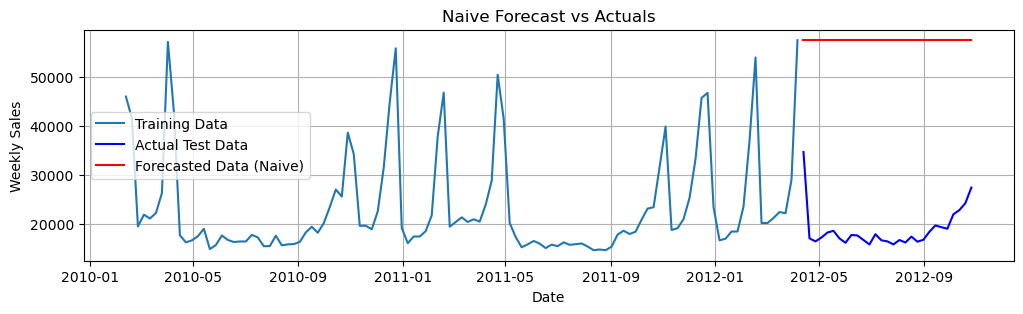

In [202]:
plt.figure(figsize=(12, 3))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Actual Test Data', color='blue')
plt.plot(y_test.index, y_pred_naive, label='Forecasted Data (Naive)', color='red')
plt.legend()
plt.title('Naive Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid()
plt.show()

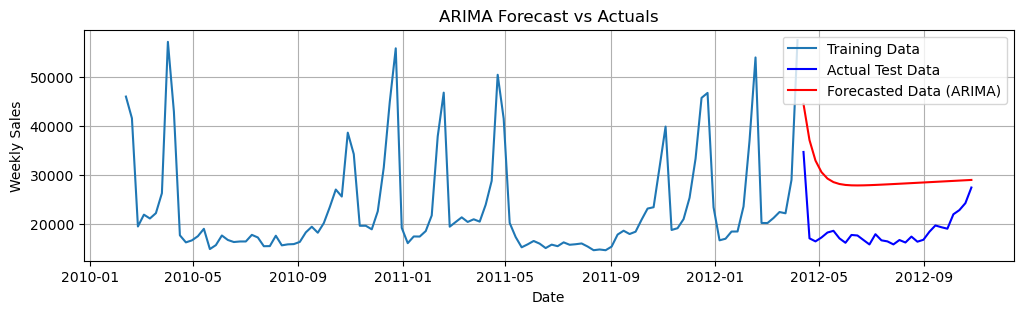

In [203]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Actual Test Data', color='blue')
plt.plot(y_test.index, y_pred_arima, label='Forecasted Data (ARIMA)', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid()
plt.show()

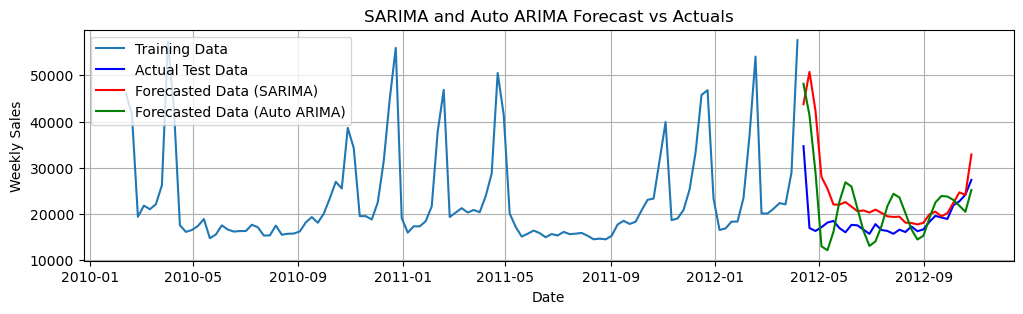

In [204]:
plt.figure(figsize=(12, 3))

# Plot training data
plt.plot(y_train.index, y_train, label='Training Data')

# Plot actual test data
plt.plot(y_test.index, y_test, label='Actual Test Data', color='blue')

# Plot ETS model predictions
plt.plot(y_test.index, y_pred_sarima, label='Forecasted Data (SARIMA)', color='red')

# Plot AutoETS model predictions
plt.plot(y_test.index, y_pred_auto, label='Forecasted Data (Auto ARIMA)', color='green')

# Add legend, title, and labels
plt.legend()
plt.title('SARIMA and Auto ARIMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid()

plt.show()

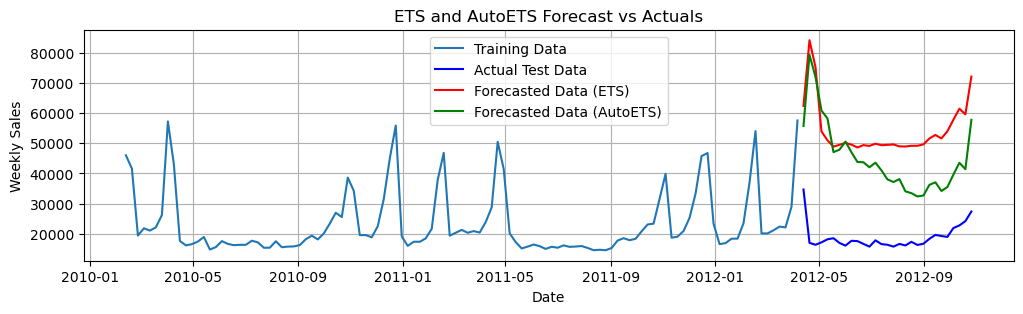

In [205]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))

# Plot training data
plt.plot(y_train.index, y_train, label='Training Data')

# Plot actual test data
plt.plot(y_test.index, y_test, label='Actual Test Data', color='blue')

# Plot ETS model predictions
plt.plot(y_test.index, y_pred_ets, label='Forecasted Data (ETS)', color='red')

# Plot AutoETS model predictions
plt.plot(y_test.index, y_pred_auto_ets, label='Forecasted Data (AutoETS)', color='green')

# Add legend, title, and labels
plt.legend()
plt.title('ETS and AutoETS Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid()

plt.show()

## Both Auto ARIMA and SARIMA demonstrate an enhanced ability to capture the recurring patterns within the data. These models excel in identifying and modeling the inherent seasonality  more effectively than simpler approaches.
